# Imports

In [1]:
import os 
path = os.getcwd()
%matplotlib inline
if path[1:5] == "Home":
    %run /Home/siv30/wad005/master/GRB/src/paths/uib.ipynb
    %run /Home/siv30/wad005/master/GRB/src/harvest_matlab_data.ipynb
    %run /Home/siv30/wad005/master/GRB/src/convert_erg.ipynb
    %run /Home/siv30/wad005/master/GRB/src/ASIMXspec.ipynb
else:
    %run /Users/andreas/phys/master/GRB/src/paths/mac.ipynb # Mac paths
    %run /Users/andreas/phys/master/GRB/src/harvest_matlab_data.ipynb
    %run /Users/andreas/phys/master/GRB/src/convert_erg.ipynb
    %run /Users/andreas/phys/master/GRB/src/ASIMXspec.ipynb

/Home/siv30/wad005/useful_py_functions/matplotlib_custom_style_and_macros.py:128: MatplotlibDeprecationWarning: Support for setting an rcParam that expects a str value to a non-str value is deprecated since 3.5 and support will be removed two minor releases later.
  rcParams['lines.marker'] = None



all UiB paths loaded


/Home/siv30/wad005/useful_py_functions/matplotlib_custom_style_and_macros.py:128: MatplotlibDeprecationWarning: Support for setting an rcParam that expects a str value to a non-str value is deprecated since 3.5 and support will be removed two minor releases later.
  rcParams['lines.marker'] = None
/Home/siv30/wad005/useful_py_functions/matplotlib_custom_style_and_macros.py:128: MatplotlibDeprecationWarning: Support for setting an rcParam that expects a str value to a non-str value is deprecated since 3.5 and support will be removed two minor releases later.
  rcParams['lines.marker'] = None



all UiB paths loaded

all UiB paths loaded
read_matlab_file.ipynb loaded successfully!

all UiB paths loaded
read_matlab_file.ipynb loaded successfully!


/Home/siv30/wad005/useful_py_functions/matplotlib_custom_style_and_macros.py:128: MatplotlibDeprecationWarning: Support for setting an rcParam that expects a str value to a non-str value is deprecated since 3.5 and support will be removed two minor releases later.
  rcParams['lines.marker'] = None


convert_erg.ipynb loaded successfully!

all UiB paths loaded

all UiB paths loaded
read_matlab_file.ipynb loaded successfully!

all UiB paths loaded
read_matlab_file.ipynb loaded successfully!

all UiB paths loaded


/Home/siv30/wad005/useful_py_functions/matplotlib_custom_style_and_macros.py:128: MatplotlibDeprecationWarning: Support for setting an rcParam that expects a str value to a non-str value is deprecated since 3.5 and support will be removed two minor releases later.
  rcParams['lines.marker'] = None
/Home/siv30/wad005/useful_py_functions/matplotlib_custom_style_and_macros.py:128: MatplotlibDeprecationWarning: Support for setting an rcParam that expects a str value to a non-str value is deprecated since 3.5 and support will be removed two minor releases later.
  rcParams['lines.marker'] = None
/Home/siv30/wad005/useful_py_functions/matplotlib_custom_style_and_macros.py:128: MatplotlibDeprecationWarning: Support for setting an rcParam that expects a str value to a non-str value is deprecated since 3.5 and support will be removed two minor releases later.
  rcParams['lines.marker'] = None
/Home/siv30/wad005/useful_py_functions/matplotlib_custom_style_and_macros.py:128: MatplotlibDeprecation

read_matlab_file.ipynb loaded successfully!
convert_erg.ipynb loaded successfully!

all UiB paths loaded
read_matlab_file.ipynb loaded successfully!

all UiB paths loaded
read_matlab_file.ipynb loaded successfully!


/Home/siv30/wad005/useful_py_functions/matplotlib_custom_style_and_macros.py:128: MatplotlibDeprecationWarning: Support for setting an rcParam that expects a str value to a non-str value is deprecated since 3.5 and support will be removed two minor releases later.
  rcParams['lines.marker'] = None
/Home/siv30/wad005/useful_py_functions/matplotlib_custom_style_and_macros.py:128: MatplotlibDeprecationWarning: Support for setting an rcParam that expects a str value to a non-str value is deprecated since 3.5 and support will be removed two minor releases later.
  rcParams['lines.marker'] = None


convert_erg.ipynb loaded successfully!
safety_time.ipynb loaded successfully!
LC_calibration loaded successfully!


# Background extraction

In [2]:
T0 = datetime.fromisoformat('2019-03-05T13:05:19.816')
df = harvest_data(fn='2019_3_5_13_3_48',T0='2019-03-05T13:05:19.816')
tus = df['tus'].to_numpy()
len(tus),type(tus)

(21914, numpy.ndarray)

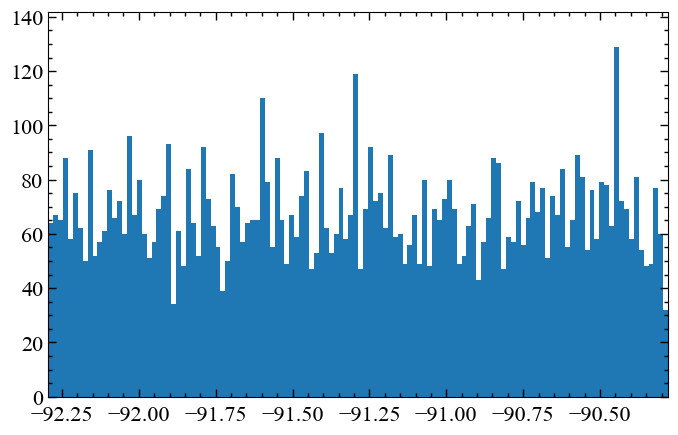

In [3]:
dt = 0.016
i=find_nearest(tus,-2)
bins_bg = np.arange(min(tus[:i]),max(tus[:i])+dt,dt)
plt.hist(tus[:i],bins=bins_bg)
plt.show()

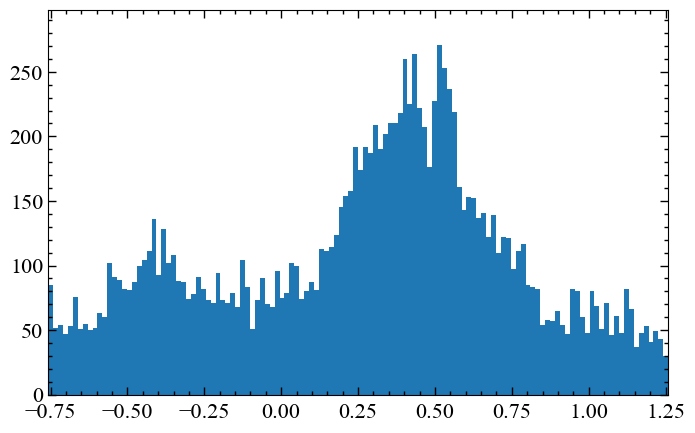

In [4]:
dt = 0.016
i=find_nearest(tus,-2)
bins_burst = np.arange(min(tus[i:]),max(tus[i:])+dt,dt)
plt.hist(tus[i:],bins=bins_burst)
plt.show()

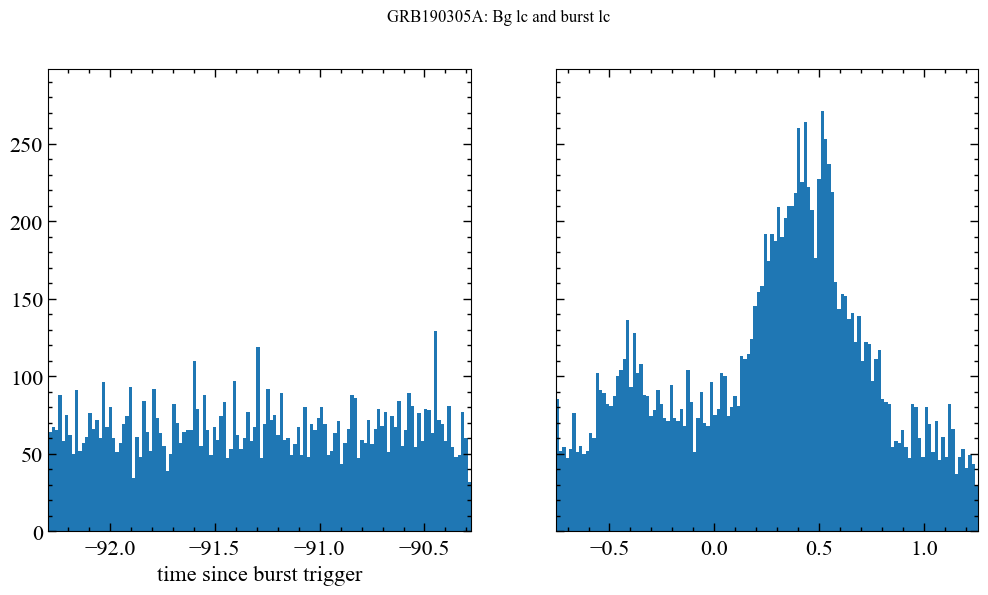

In [5]:
fig, (ax1, ax2) = plt.subplots(1, 2,sharey=True,figsize=(12, 6))
fig.suptitle('GRB190305A: Bg lc and burst lc')
ax1.hist(tus[:i],bins=bins_bg)
ax2.hist(tus[i:],bins=bins_burst)
ax1.set_xlabel("time since burst trigger")
plt.show()

In [6]:
print("burst T0: ", T0)
print("bg T0:",T0-timedelta(seconds=90))
print("iss lon,lat position (at T0): ",84.887, -51.772)
print("iss lon,lat position (at bg): ", 75.929,-51.595)
print("location: indian ocean")
print("travelled ~620 km from bg to burst (~90 sec)")

burst T0:  2019-03-05 13:05:19.816000
bg T0: 2019-03-05 13:03:49.816000
iss lon,lat position (at T0):  84.887 -51.772
iss lon,lat position (at bg):  75.929 -51.595
location: indian ocean
travelled ~620 km from bg to burst (~90 sec)


# Calibreating energy channels

In [7]:
#need to truncate the df to the bg
i = find_nearest(tus,-2)
df_bg = df.iloc[:i]
df_bg

,year,month,day,hour,minute,second,energy_ch,dau,det,datetime,tus
0,2019,3,5,13,3,47.521628,1397,1,2,2019-03-05 13:03:47.521628443,-92.294372
43828,2019,3,5,13,3,47.521628,1397,1,2,2019-03-05 13:03:47.521628443,-92.294372
65742,2019,3,5,13,3,47.521628,1397,1,2,2019-03-05 13:03:47.521628443,-92.294372
21914,2019,3,5,13,3,47.521628,1397,1,2,2019-03-05 13:03:47.521628443,-92.294372
1,2019,3,5,13,3,47.522101,84,1,2,2019-03-05 13:03:47.522100556,-92.293899
...,...,...,...,...,...,...,...,...,...,...,...
74180,2019,3,5,13,3,49.53039,35,2,1,2019-03-05 13:03:49.530390389,-90.285610
52267,2019,3,5,13,3,49.530741,149,1,1,2019-03-05 13:03:49.530740972,-90.285259
8439,2019,3,5,13,3,49.530741,149,1,1,2019-03-05 13:03:49.530740972,-90.285259
74181,2019,3,5,13,3,49.530741,149,1,1,2019-03-05 13:03:49.530740972,-90.285259


In [8]:
coefs = get_coefs(T0)
coefs

{'dau_1_det_1': {'a': 0.005056, 'b': 7.8833, 'c': 57.8059},
 'dau_1_det_2': {'a': -0.000256, 'b': 17.7142, 'c': 15.1718},
 'dau_1_det_3': {'a': 0.003538, 'b': 9.21618, 'c': 49.5092},
 'dau_2_det_1': {'a': 0.007493, 'b': 4.6849, 'c': 130.9879},
 'dau_2_det_2': {'a': 0.004786, 'b': 10.5899, 'c': 42.4091},
 'dau_2_det_3': {'a': 0.005455, 'b': 8.3616, 'c': 48.51079},
 'dau_3_det_1': {'a': -0.001532, 'b': 21.1949, 'c': -10.2295},
 'dau_3_det_2': {'a': -0.003828, 'b': 25.3863, 'c': -9.64767},
 'dau_3_det_3': {'a': -0.001969, 'b': 21.9612, 'c': 7.89434},
 'dau_4_det_1': {'a': 0.003962, 'b': 10.3366, 'c': 58.0892},
 'dau_4_det_2': {'a': 0.004284, 'b': 11.1893, 'c': 23.54682},
 'dau_4_det_3': {'a': 0.002769, 'b': 11.8369, 'c': 18.7551}}

In [12]:
erg,dau,det = df_bg['energy_ch'].to_numpy(),df_bg['dau'].to_numpy()+1,df_bg['det'].to_numpy()+1
len(erg),len(dau),len(det)

(33760, 33760, 33760)

In [10]:
#keV,cal_abc = convert_erg(erg,dau,det,T0)

In [14]:
keV,cal_abc = convert_erg(erg,dau,det,T0)

In [15]:
keV

array([22375.693085, 22375.693085, 22375.693085, ...,  1726.558186,
        1726.558186,  1726.558186])

In [18]:
df_bg['keV']=keV

/var/folders/q_/b8y8kqjd57q3wqvw3vyz1mrw0000gn/T/ipykernel_13716/3325539457.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_bg['keV']=keV


In [ ]:
#TODO: Shift the tus array by the tlagg=0.472s

In [19]:
df_bg

,year,month,day,hour,minute,second,energy_ch,dau,det,datetime,tus,keV
0,2019,3,5,13,3,47.521628,1397,1,2,2019-03-05 13:03:47.521628443,-92.294372,22375.693085
43828,2019,3,5,13,3,47.521628,1397,1,2,2019-03-05 13:03:47.521628443,-92.294372,22375.693085
65742,2019,3,5,13,3,47.521628,1397,1,2,2019-03-05 13:03:47.521628443,-92.294372,22375.693085
21914,2019,3,5,13,3,47.521628,1397,1,2,2019-03-05 13:03:47.521628443,-92.294372,22375.693085
1,2019,3,5,13,3,47.522101,84,1,2,2019-03-05 13:03:47.522100556,-92.293899,789.375670
...,...,...,...,...,...,...,...,...,...,...,...,...
74180,2019,3,5,13,3,49.53039,35,2,1,2019-03-05 13:03:49.530390389,-90.285610,874.183530
52267,2019,3,5,13,3,49.530741,149,1,1,2019-03-05 13:03:49.530740972,-90.285259,1726.558186
8439,2019,3,5,13,3,49.530741,149,1,1,2019-03-05 13:03:49.530740972,-90.285259,1726.558186
74181,2019,3,5,13,3,49.530741,149,1,1,2019-03-05 13:03:49.530740972,-90.285259,1726.558186


In [30]:
df_keV = keV_hist(df=df_bg,
                  time_interval=(-92,-89),
                  keV_interval='max',
                  convert_seconds=False)

Computing whole spectrum (10-1e5 keV)
n triggers in time interval  28729
n triggers are within bounds  28729
keV bins are set for HED
Energies binned!


/var/folders/q_/b8y8kqjd57q3wqvw3vyz1mrw0000gn/T/ipykernel_13716/4290521024.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.sort_values(by=['tus'],inplace=True) #first sorting by tus in increasing order


In [32]:
df_keV.head()

,bins_keV,counts,poisson_error_counts
0,10.00000,0,0.0
1,12.58925,0,0.0
2,15.84893,0,0.0
3,19.95262,0,0.0
4,25.11886,0,0.0


In [59]:
BAK_dict = {
'USER': ['Andreas Ramsli','Username of creator of this fits file'], #<str>
'T0TIME':['2019-03-05T13:05:19.816','Trigger time UT format=YYYY-MM-DDThh:mm:ss.fff'], #<str> 
'TSTART': [-92.294,'[s] Start time of background spectrum accumulation'], #<float> [s] Start time of spectrum accumulation relative to T0TIME
'TSTOP': [-90.285,'End time of background spectrum accumulation'], #<float> [s]
'EXPOSURE': [2.00874,'[s] Integration time in seconds for the BAK data'], #<float> 
'OBJECT': ['GRB190305A','Name of the observed object'], #<str> 
'RA_OBJ': [11.627,'[deg] RA of source'], #<float> 
'DEC_OBJ':  [-50.349,'[deg] Dec of source'], #<float>
'FILENAME': ['HED_GRB190305A.bak','Backgorund filename for fits file'] #<str>  ('example.bak')
}
#More keys can be declated. Set generatePHA(see_template=True) to view avalible keys,values & comments from the template HDR's

In [34]:
print(T0)

2019-03-05 13:05:19.816000


In [55]:
df_keV.tail()

,bins_keV,counts,poisson_error_counts
36,39810.72,1840,42.895221
37,50118.72,48,6.928203
38,63095.73,0,0.000000
39,79432.82,0,0.000000
40,100000.00,0,0.000000


# BURST
    TODO: To make a fits file out of the data harvested, one needs to implement the safetytime criteria.
    To implement that, I have to create a column for the adr for the trigger.
    
    tlagg= 0.472s

In [3]:
df = make_adr(df)
keV,cal_abc = convert_erg(df['energy_ch'].to_numpy(),df['dau'].to_numpy(),df['det'].to_numpy(),T0)
df['keV'] = keV
df['tus'] = df['tus'].to_numpy(np.float64)*1e6
df.sort_values(by=['adr','tus'],inplace=True)
st,dt = get_st(df),get_dt(df)
df['st'],df['dt'] = np.array(st),np.array(dt)

In [4]:
df.head(25)

,year,month,day,hour,minute,second,energy_ch,dau,det,datetime,tus,adr,keV,st,dt
43841,2019,3,5,13,3,47.525428,28,1,1,2019-03-05 13:03:47.525427861,-9.229057e+07,1,282.502204,0.000000,0.000
21927,2019,3,5,13,3,47.525428,28,1,1,2019-03-05 13:03:47.525427861,-9.229057e+07,1,282.502204,0.000000,0.000
13,2019,3,5,13,3,47.525428,28,1,1,2019-03-05 13:03:47.525427861,-9.229057e+07,1,282.502204,0.000000,0.000
65755,2019,3,5,13,3,47.525428,28,1,1,2019-03-05 13:03:47.525427861,-9.229057e+07,1,282.502204,0.000000,0.000
43843,2019,3,5,13,3,47.525878,43,1,1,2019-03-05 13:03:47.525877778,-9.229012e+07,1,406.136344,0.061363,449.917
21929,2019,3,5,13,3,47.525878,43,1,1,2019-03-05 13:03:47.525877778,-9.229012e+07,1,406.136344,0.061363,0.000
15,2019,3,5,13,3,47.525878,43,1,1,2019-03-05 13:03:47.525877778,-9.229012e+07,1,406.136344,0.061363,0.000
65757,2019,3,5,13,3,47.525878,43,1,1,2019-03-05 13:03:47.525877778,-9.229012e+07,1,406.136344,0.061363,0.000
65772,2019,3,5,13,3,47.530015,52,1,1,2019-03-05 13:03:47.530014972,-9.228599e+07,1,481.408924,0.814089,4137.194
30,2019,3,5,13,3,47.530015,52,1,1,2019-03-05 13:03:47.530014972,-9.228599e+07,1,481.408924,0.814089,0.000


In [7]:
print(find_nearest(df['tus'].to_numpy(),-2))

41304


In [ ]:
df

,year,month,day,hour,minute,second,energy_ch,dau,det,datetime,tus,adr,keV,st,dt
65736,2019,3,5,13,5,21.065335,33,4,3,2019-03-05 13:05:21.065335332,1249335.332,12,412.388241,0.123882,0.000
87651,2019,3,5,13,5,21.065338,1330,4,3,2019-03-05 13:05:21.065338167,1249338.167,12,20659.916200,23.000000,2.835
65737,2019,3,5,13,5,21.065338,1330,4,3,2019-03-05 13:05:21.065338167,1249338.167,12,20659.916200,23.000000,0.000
43823,2019,3,5,13,5,21.065338,1330,4,3,2019-03-05 13:05:21.065338167,1249338.167,12,20659.916200,23.000000,0.000
21909,2019,3,5,13,5,21.065338,1330,4,3,2019-03-05 13:05:21.065338167,1249338.167,12,20659.916200,23.000000,0.000


In [38]:
st_arr,dt_arr = df["st"].to_numpy(),df["dt"].to_numpy()
def get_flag(st_arr,dt_arr):
    flag = []
    i = 0
    while i < len(st_arr):
        if i == 0:
            flag.append(False)
            i += 1

        elif dt_arr[i] >= st_arr[i-1]:
            flag.append(False)
            i+=1

        elif dt_arr[i] <= st_arr[i-1]:
            st,diff = st_arr[i-1], dt_arr[i]
            flags = 0
            i += 1
            #have to take into account that there can be triggers incoming while the st have not been reset
            while diff < st: #problem here
                if i == len(st_arr):
                    flags+=1
                    flag.extend(flags*[True])
                    return flag
                else:
                    diff += dt_arr[i]
                    flags += 1
                    i +=1
            flag.extend(flags*[True])
            i -= 1
        else:
            flag.append(False)
            i += 1

In [39]:
flag = get_flag(st_arr,dt_arr)

In [40]:
len(flag),len(st_arr),len(dt_arr)

(87656, 87656, 87656)

In [42]:
df['flag'] = np.array(flag)

In [47]:
f = np.array(flag)
len(np.where(f == True)[0])

53536

In [49]:
len(dt_arr)-53536

34120

In [50]:
flag_label = []
for flag_idx,row in df.iterrows():
    if row["flag"]==True:
        flag_label.append(flag_idx)

print("Removed " + str(len(flag_label)) + " flags from df")
df.drop(labels=flag_label,inplace=True)

Removed 53536 flags from df


In [51]:
df

,year,month,day,hour,minute,second,energy_ch,dau,det,datetime,tus,adr,keV,st,dt,flag
43841,2019,3,5,13,3,47.525428,28,1,1,2019-03-05 13:03:47.525427861,-9.229057e+07,1,282.502204,0.000000,0.000,False
21927,2019,3,5,13,3,47.525428,28,1,1,2019-03-05 13:03:47.525427861,-9.229057e+07,1,282.502204,0.000000,0.000,False
13,2019,3,5,13,3,47.525428,28,1,1,2019-03-05 13:03:47.525427861,-9.229057e+07,1,282.502204,0.000000,0.000,False
65755,2019,3,5,13,3,47.525428,28,1,1,2019-03-05 13:03:47.525427861,-9.229057e+07,1,282.502204,0.000000,0.000,False
43843,2019,3,5,13,3,47.525878,43,1,1,2019-03-05 13:03:47.525877778,-9.229012e+07,1,406.136344,0.061363,449.917,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
87629,2019,3,5,13,5,21.059416,1816,4,3,2019-03-05 13:05:21.059416222,1.243416e+06,12,30646.328764,25.517063,36.778,False
87636,2019,3,5,13,5,21.061388,38,4,3,2019-03-05 13:05:21.061387611,1.245388e+06,12,472.555736,0.725557,1971.389,False
43812,2019,3,5,13,5,21.064034,758,4,3,2019-03-05 13:05:21.064033667,1.248034e+06,12,10582.093016,19.465674,2646.056,False
21908,2019,3,5,13,5,21.065335,33,4,3,2019-03-05 13:05:21.065335332,1.249335e+06,12,412.388241,0.123882,1301.665,False


# FITS

In [63]:
%run /Users/andreas/phys/master/GRB/xspec/ASIM/ASIMFits/BAK/ASIMbak.ipynb
%run /Users/andreas/phys/master/GRB/xspec/ASIM/ASIMFits/RSP/ASIMrsp.ipynb
%run /Users/andreas/phys/master/GRB/xspec/ASIM/ASIMFits/RSP/find_closest_DRM.ipynb

In [60]:
generateBAK(BAK_dict=BAK_dict,
            bakCounts=df_keV['counts'][1:].to_numpy(dtype=np.int16),
            stat_err=df_keV['poisson_error_counts'][1:].to_numpy(dtype=np.float32),
            bin_lo=df_keV['bins_keV'][:-1].to_numpy(dtype=np.float32),
            bin_hi=df_keV['bins_keV'][1:].to_numpy(dtype=np.float32)
           )

In [47]:
os.getcwd()

'/Users/andreas/phys/master/GRB/xspec/ASIM/GRB190305A'

### RSP
    Used from theta,phi angles

In [61]:
theta,phi=133.904,-2.076

In [64]:
find_DRM_file(dir_path='/Users/andreas/phys/master/HED_DRM/',
             theta=theta,phi=phi)

'HED_drm_mats_135.00_0.00.txt'

In [65]:
rsp_dict = {
    'USER': ['Andreas Ramsli','Username of creator of this fits file'], #<str>
    'T0TIME':['2019-03-05T13:05:20.288','Trigger time UT format=YYYY-MM-DDThh:mm:ss.fff'], #<str> 
    'TSTART': [0.768,'[s] Start time of spectrum accumulation'], #<float> [s] Start time of spectrum accumulation relative to T0TIME
    'TSTOP': [1.280,'End time of spectrum accumulation'], #<float> [s]
    'EXPOSURE': [0.512,'[s] Integration time in seconds for the PHA data'], #<float> 
    'OBJECT': ['GRB190305A','Name of the observed object'], #<str> 
    'RA_OBJ': [340.399,'[deg] RA of source'], #<float> 
    'DEC_OBJ':  [-10.588,'[deg] Dec of source'], #<float>
    'FILENAME': ['HED_GRB190305A.rsp','RSP filename'] #<str>  ('example.pha')
}

In [67]:
generateRSP(RSP_dict=rsp_dict, DRM_fname='HED_drm_mats_135.00_0.00.txt', 
            bin_lo=df_keV['bins_keV'][:-1].to_numpy(dtype=np.float32),
            bin_hi=df_keV['bins_keV'][1:].to_numpy(dtype=np.float32),
            theta=theta,phi=phi,see_headers=False)

In [66]:
df_keV['bins_keV'][1:].to_numpy(dtype=np.float32)

,bins_keV,counts,poisson_error_counts
0,10.00000,0,0.000000
1,12.58925,0,0.000000
2,15.84893,0,0.000000
3,19.95262,0,0.000000
4,25.11886,0,0.000000
5,31.62278,0,0.000000
6,39.81072,0,0.000000
7,50.11872,0,0.000000
8,63.09573,0,0.000000
9,79.43282,0,0.000000
